<a href="https://colab.research.google.com/github/killercookiee/DeepM/blob/main/DeepM_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/killercookiee/DeepM

Cloning into 'DeepM'...
remote: Enumerating objects: 1145, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 1145 (delta 24), reused 59 (delta 14), pack-reused 1062 (from 1)
Receiving objects: 100% (1145/1145), 317.10 MiB | 15.59 MiB/s, done.
Resolving deltas: 100% (313/313), done.
Updating files: 100% (856/856), done.


Understanding the File format

Neuroimaging Informatics Technology Initiative
NIfTI is designed to handle 3D (volume) and 4D (time-series) data, which is common in brain imaging, especially for functional MRI (fMRI) studies
NIfTI files can also be stored in a compressed .nii.gz format to save disk space

4 D --> Height + Width + Depth + Time

We are working with pairs of files. Example
1. Say MRI scan of heart
2. Corresponding segmentation mask file -> i.e. a label that marks different part of the image, like heart chambers, valves, etc

Possibly

patient001_4d.nii.gz -> 4D file (Sequence of 3d images over time), not used for segmentation
patient001_frame01.nii.gz -> A single 2D slice of the 3D MRI data. Image file used for traning the model
patient001_frame01_gt.nii.gz -> It contains labels marking the regions of interest in the image

# Imports

In [2]:
%pip install opencv-python --quiet
%pip install scikit-image --quiet

In [3]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from skimage.transform import resize
import random
import plotly.graph_objects as go  # Graph Objects module comprises visuals like Heatmaps, Figures, etc
import torch.nn.functional as F


# Training and Testing Data List

In [4]:
def select_new_training_data(dataset_dir):
    data_anomolies = ['038', '085', '057', '089', '100']

    training_data_list = {}
    for k in ['training']:

        subset_dir = os.path.join(dataset_dir, k)
        training_data_list[k] = []

        for patient in sorted(os.listdir(subset_dir)):

            patient_dir = os.path.join(subset_dir, patient)

            # Skip files that are not directories
            if not os.path.isdir(patient_dir):
                continue

            for file in sorted(os.listdir(patient_dir)):
                if file[-8] == 't' and file[-21:-18] not in data_anomolies:

                    image_name = '{0}/{1}_frame{2}.nii.gz'.format(patient_dir, patient, file[-12:-10])
                    segt_name = '{0}/{1}_frame{2}_gt.nii.gz'.format(patient_dir, patient, file[-12:-10])

                    if os.path.exists(image_name) and os.path.exists(segt_name):
                        training_data_list[k] += [[image_name, segt_name, patient]]

    return training_data_list



def select_new_testing_data(dataset_dir):
    testing_data_list = {}

    for k in ['testing']:
        subset_dir = os.path.join(dataset_dir, k)
        testing_data_list[k] = []

        for patient in sorted(os.listdir(subset_dir)):

            patient_dir = os.path.join(subset_dir, patient)

            # Skip files that are not directories
            if not os.path.isdir(patient_dir):
                continue

            for file in sorted(os.listdir(patient_dir)):
                if file[-8] != 'd' and file[-8] != 'I':

                    image_name = '{0}/{1}_frame{2}.nii.gz'.format(patient_dir, patient, file[-12:-10])
                    segt_name = '{0}/{1}_frame{2}_gt.nii.gz'.format(patient_dir, patient, file[-12:-10])

                    if os.path.exists(image_name) and os.path.exists(segt_name):
                        testing_data_list[k] += [[image_name, segt_name, patient]]

    return testing_data_list



training_data_list = select_new_training_data("./DeepM/MIS-working-database")
testing_data_list = select_new_testing_data("./DeepM/MIS-working-database")

In [5]:
# training_data_list

In [6]:
# testing_data_list

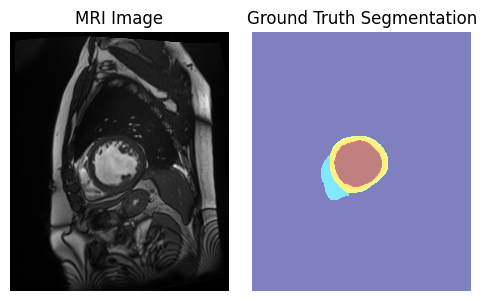

In [7]:
def visualize_ground_truth(training_data_list, index=0):
    # Get the image and segmentation files for a particular index
    image_file = training_data_list['training'][index][0]
    segt_file = training_data_list['training'][index][1]

    # Load the MRI image and its ground truth label
    img = nib.load(image_file)
    segt = nib.load(segt_file)

    img_data = img.get_fdata()
    segt_data = segt.get_fdata()

    # Select a slice from the image (you can change this depending on the 3D data)
    slice_idx = img_data.shape[2] // 2  # Choose the middle slice for visualization
    img_slice = img_data[:, :, slice_idx]
    segt_slice = segt_data[:, :, slice_idx]

    # Plot the MRI image and its corresponding ground truth label
    fig, axes = plt.subplots(1, 2, figsize=(5, 3))

    # Display the MRI image
    axes[0].imshow(img_slice.T, cmap='gray')
    axes[0].set_title('MRI Image')
    axes[0].axis('off')

    # Display the ground truth label (segmentation mask)
    axes[1].imshow(segt_slice.T, cmap='jet', alpha=0.5)
    axes[1].set_title('Ground Truth Segmentation')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

    # segt_data

# Example: Visualize the first image and its ground truth
visualize_ground_truth(training_data_list, index=0)

In [8]:
from matplotlib.colors import ListedColormap

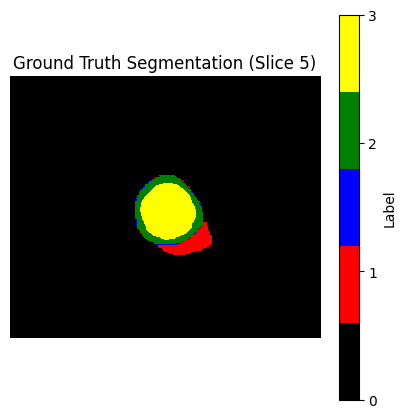

In [9]:
def visualize_ground_truth(training_data_list, index=0):
    # Get the segmentation file for a particular index
    segt_file = training_data_list['training'][index][1]

    # Load the segmentation (ground truth) file
    segt = nib.load(segt_file)
    segt_data = segt.get_fdata()

    # Choose a slice to visualize (assuming 3D data)
    # You can choose a specific axis and slice index if needed
    slice_idx = segt_data.shape[2] // 2  # Middle slice along the z-axis
    slice_data = segt_data[:, :, slice_idx]

    # Create a colormap for the unique values
    unique_values = np.unique(slice_data)
    cmap = ListedColormap(['black', 'red', 'blue', 'green', 'yellow'])

    # Plot the slice
    plt.figure(figsize=(5, 5))
    plt.imshow(slice_data, cmap=cmap, origin='lower')
    cbar = plt.colorbar()
    cbar.set_ticks(unique_values)
    cbar.set_label('Label')
    plt.title(f'Ground Truth Segmentation (Slice {slice_idx})')
    plt.axis('off')
    plt.show()

# Example: Check the pixel values of the ground truth
# unique_values = check_ground_truth_values(training_data_list, index=0)

# Example: Visualize the ground truth mask
visualize_ground_truth(training_data_list, index=0)

In [10]:
# ## Downloading the pretrained model
# # !mkdir pretrained_ckpt
# # !wget -P pretrained_ckpt/ https://drive.google.com/uc?id=1UC3XOoezeum0uck4KBVGa8osahs6rKUY

# from google.colab import files
# files.upload()  # Use the upload widget to upload the pretrained model file


In [11]:
# # !ls /content
# !find /content -name "swin_tiny_patch4_window7_224.pth"

In [12]:
type(training_data_list)

dict

Converting NII.GZ to slices of .tif format


In [15]:
import os
import nibabel as nib
import numpy as np
from PIL import Image

In [16]:
# Function to split filenames
def split_filename(filepath):
    path = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    base, ext = os.path.splitext(filename)
    if ext == '.gz':
        base, ext2 = os.path.splitext(base)
        ext = ext2 + ext
    return path, base, ext


def nii_to_tif(input_path, output_dir, axis=2):
    _, base, ext = split_filename(input_path)
    img = nib.load(input_path).get_fdata().astype(np.float32).squeeze()

    if img.ndim != 3:
        print(f"Only 3D data supported. File {base}{ext} has dimension {img.ndim}. Skipping.")
        return

    os.makedirs(output_dir, exist_ok=True)

    for i in range(img.shape[axis]):
        if axis == 0:
            slice_img = img[i, :, :]
        elif axis == 1:
            slice_img = img[:, i, :]
        else:
            slice_img = img[:, :, i]

        # Normalize and save as 16-bit TIFF
        slice_img = np.clip(slice_img, 0, np.max(slice_img))  # Ensure non-negative
        slice_img = (slice_img / np.max(slice_img) * 65535).astype(np.uint16)
        slice_tif = Image.fromarray(slice_img, mode='I;16')
        slice_tif.save(os.path.join(output_dir, f"{base}_{i:04}.tif"), compression="tiff_adobe_deflate")

def nii_to_tif_labels(input_path, output_dir, axis=2):
    _, base, ext = split_filename(input_path)
    label_img = nib.load(input_path).get_fdata().astype(np.int32).squeeze()

    if label_img.ndim != 3:
        print(f"Only 3D data supported. File {base}{ext} has dimension {label_img.ndim}. Skipping.")
        return

    os.makedirs(output_dir, exist_ok=True)

    for i in range(label_img.shape[axis]):
        if axis == 0:
            slice_label = label_img[i, :, :]
        elif axis == 1:
            slice_label = label_img[:, i, :]
        else:
            slice_label = label_img[:, :, i]

        # Save the label slice as 16-bit TIFF (to preserve class IDs)
        slice_label_tif = Image.fromarray(slice_label.astype(np.uint16), mode='I;16')
        slice_label_tif.save(os.path.join(output_dir, f"{base}_{i:04}.tif"), compression="tiff_adobe_deflate")





In [17]:
# Process training data
for entry in training_data_list['training']:
    img_path, gt_path, patient_id = entry

    # Process and save images
    nii_to_tif(img_path, f"./output/training/images/{patient_id}")

    # Process and save labels
    nii_to_tif_labels(gt_path, f"./output/training/labels/{patient_id}")

# Process testing data
for entry in testing_data_list['testing']:
    img_path, gt_path, patient_id = entry

    # Process and save images
    nii_to_tif(img_path, f"./output/testing/images/{patient_id}")

    # Process and save labels
    nii_to_tif_labels(gt_path, f"./output/testing/labels/{patient_id}")


Unique values in the label slice: [0 1 2 3]


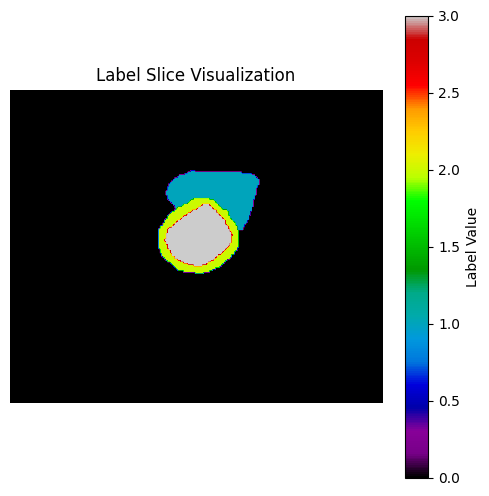

In [18]:
## Visualising a slice


from tifffile import imread

# Path to the label slice (adjust the path as needed)
slice_path = "./output/training/labels/patient001/patient001_frame01_gt_0001.tif"

# Load the slice
label_slice = imread(slice_path)

# Check unique values in the label slice
unique_values = np.unique(label_slice)
print(f"Unique values in the label slice: {unique_values}")

# Visualize the slice
plt.figure(figsize=(6, 6))
plt.imshow(label_slice, cmap='nipy_spectral')  # Use a distinct colormap for labels
plt.colorbar(label="Label Value")
plt.title("Label Slice Visualization")
plt.axis("off")
plt.show()



In [19]:
# pip install imageio
!pip install pillow
import tensorflow as tf

In [20]:
from PIL import Image
import os

def compare_image_label_sizes_recursive(image_dir, label_dir):
    image_paths = []
    label_paths = []

    # Traverse image directory and collect .tif file paths
    for root, _, files in os.walk(image_dir):
        for file in files:
            if file.endswith(".tif"):
                image_paths.append(os.path.join(root, file))

    # Traverse label directory and collect .tif file paths
    for root, _, files in os.walk(label_dir):
        for file in files:
            if file.endswith(".tif"):
                label_paths.append(os.path.join(root, file))

    # Sort the collected paths to ensure proper alignment
    image_paths = sorted(image_paths)
    label_paths = sorted(label_paths)

    # Compare sizes
    for img_path, label_path in zip(image_paths, label_paths):
        with Image.open(img_path) as img:
            img_size = img.size  # (width, height)
        with Image.open(label_path) as label:
            label_size = label.size

        print(f"{os.path.basename(img_path)}: Image Size = {img_size}, Label Size = {label_size}")


In [21]:
# Example usage
compare_image_label_sizes_recursive("./output/training/images/patient010", "./output/training/labels/patient010")
compare_image_label_sizes_recursive("./output/training/images/patient005", "./output/training/labels/patient005")
compare_image_label_sizes_recursive("./output/training/images/patient099", "./output/training/labels/patient099")

patient010_frame01_0000.tif: Image Size = (256, 208), Label Size = (256, 208)
patient010_frame01_0001.tif: Image Size = (256, 208), Label Size = (256, 208)
patient010_frame01_0002.tif: Image Size = (256, 208), Label Size = (256, 208)
patient010_frame01_0003.tif: Image Size = (256, 208), Label Size = (256, 208)
patient010_frame01_0004.tif: Image Size = (256, 208), Label Size = (256, 208)
patient010_frame01_0005.tif: Image Size = (256, 208), Label Size = (256, 208)
patient010_frame01_0006.tif: Image Size = (256, 208), Label Size = (256, 208)
patient010_frame01_0007.tif: Image Size = (256, 208), Label Size = (256, 208)
patient010_frame01_0008.tif: Image Size = (256, 208), Label Size = (256, 208)
patient010_frame01_0009.tif: Image Size = (256, 208), Label Size = (256, 208)
patient010_frame02_0000.tif: Image Size = (256, 208), Label Size = (256, 208)
patient010_frame02_0001.tif: Image Size = (256, 208), Label Size = (256, 208)
patient010_frame02_0002.tif: Image Size = (256, 208), Label Size

In [ ]:
# 3. How to Minimize Quality Loss
# For Images:

#     Use bicubic interpolation for smoother resizing.
#     If resizing down (reducing size), the model may lose fine details. Upscaling (increasing size) doesn't restore information but can help standardize input sizes.

# For Labels:

#     Use nearest-neighbor interpolation to preserve discrete classes and ensure boundaries remain sharp.

In [27]:
import os
from PIL import Image, ImageOps
import numpy as np
from tqdm import tqdm

# Padding function for image and label
def pad_and_label(input_path, target_size=(256, 256), pad_value=0):
    # Open the image
    with Image.open(input_path) as img:
        # Pad the image
        padded_img = ImageOps.pad(img, target_size, method=Image.Resampling.NEAREST, color=0)  # Pad with 0 (black)
        padded_img.save(input_path)  # Overwrite the file in place

    return input_path  # Return the file path after padding

# Function to gather the training data in a dictionary
def select_new_training_data(dataset_dir):
    training_data_dict = {"images": [], "labels": []}

    for k in ['training']:
        subset_dir = os.path.join(dataset_dir, k)

        for patient in sorted(os.listdir(subset_dir)):
            patient_dir = os.path.join(subset_dir, patient)

            if not os.path.isdir(patient_dir):
                continue

            # Use tqdm to show progress as we process each patient
            for root, dirs, files in tqdm(os.walk(patient_dir), desc=f"Processing {patient}"):
                for file in files:
                    if file.endswith('.tif'):
                        file_path = os.path.join(root, file)

                        if 'images' in root:  # Image file found in 'images' subdirectory
                            padded_img_path = pad_and_label(file_path)  # Process and overwrite image
                            training_data_dict["images"].append(padded_img_path)  # Add to images list
                        elif 'labels' in root:  # Label file found in 'labels' subdirectory
                            padded_label_path = pad_and_label(file_path)  # Process and overwrite label
                            training_data_dict["labels"].append(padded_label_path)  # Add to labels list

    return training_data_dict

# Function to gather the testing data in a dictionary
def select_new_testing_data(dataset_dir):
    testing_data_dict = {"images": [], "labels": []}

    for k in ['testing']:
        subset_dir = os.path.join(dataset_dir, k)

        for patient in sorted(os.listdir(subset_dir)):
            patient_dir = os.path.join(subset_dir, patient)

            if not os.path.isdir(patient_dir):
                continue

            # Use tqdm to show progress as we process each patient
            for root, dirs, files in tqdm(os.walk(patient_dir), desc=f"Processing {patient}"):
                for file in files:
                    if file.endswith('.tif'):
                        file_path = os.path.join(root, file)

                        if 'images' in root:  # Image file found in 'images' subdirectory
                            padded_img_path = pad_and_label(file_path)  # Process and overwrite image
                            testing_data_dict["images"].append(padded_img_path)  # Add to images list
                        elif 'labels' in root:  # Label file found in 'labels' subdirectory
                            padded_label_path = pad_and_label(file_path)  # Process and overwrite label
                            testing_data_dict["labels"].append(padded_label_path)  # Add to labels list

    return testing_data_dict


# Example usage

# Process and gather training data as a dictionary
training_data_dict = select_new_training_data("./output")

# Process and gather testing data as a dictionary
testing_data_dict = select_new_testing_data("./output")

# Now `training_data_dict` and `testing_data_dict` contain the paths to padded images and labels.


Processing images: 96it [00:03, 24.90it/s]
Processing labels: 96it [00:02, 33.53it/s]
Processing images: 51it [00:02, 17.32it/s]
Processing labels: 51it [00:01, 29.06it/s]


In [28]:
# Example usage
compare_image_label_sizes_recursive("./output/training/images/patient010", "./output/training/labels/patient010")
compare_image_label_sizes_recursive("./output/training/images/patient005", "./output/training/labels/patient005")
compare_image_label_sizes_recursive("./output/training/images/patient099", "./output/training/labels/patient099")

patient010_frame01_0000.tif: Image Size = (256, 256), Label Size = (256, 256)
patient010_frame01_0001.tif: Image Size = (256, 256), Label Size = (256, 256)
patient010_frame01_0002.tif: Image Size = (256, 256), Label Size = (256, 256)
patient010_frame01_0003.tif: Image Size = (256, 256), Label Size = (256, 256)
patient010_frame01_0004.tif: Image Size = (256, 256), Label Size = (256, 256)
patient010_frame01_0005.tif: Image Size = (256, 256), Label Size = (256, 256)
patient010_frame01_0006.tif: Image Size = (256, 256), Label Size = (256, 256)
patient010_frame01_0007.tif: Image Size = (256, 256), Label Size = (256, 256)
patient010_frame01_0008.tif: Image Size = (256, 256), Label Size = (256, 256)
patient010_frame01_0009.tif: Image Size = (256, 256), Label Size = (256, 256)
patient010_frame02_0000.tif: Image Size = (256, 256), Label Size = (256, 256)
patient010_frame02_0001.tif: Image Size = (256, 256), Label Size = (256, 256)
patient010_frame02_0002.tif: Image Size = (256, 256), Label Size

In [38]:
import os
import re

# Function to align images with corresponding labels
def align_images_and_labels(images, labels):
    aligned_images = []
    aligned_labels = []

    # Compile the regular expressions to avoid compiling them repeatedly
    img_regex = re.compile(r"^(patient\d+)_frame(\d+)_000(\d+)\.tif$")
    label_regex = re.compile(r"^(patient\d+)_frame(\d+)_gt_000(\d+)\.tif$")

    # Convert labels into a dictionary to speed up lookup by key
    label_dict = {}
    for label in labels:
        label_filename = os.path.basename(label)
        label_match = label_regex.match(label_filename)
        if label_match:
            label_patient, label_frame, label_final = label_match.groups()
            label_dict[(label_patient, label_frame, label_final)] = label

    # Iterate through each image and try to find the corresponding label
    for img in images:
        img_filename = os.path.basename(img)
        img_match = img_regex.match(img_filename)

        if img_match:
            img_patient, img_frame, img_final = img_match.groups()
            label_key = (img_patient, img_frame, img_final)

            # Check if the corresponding label exists in the dictionary
            if label_key in label_dict:
                aligned_images.append(img)
                aligned_labels.append(label_dict[label_key])

    return aligned_images, aligned_labels

# Function to align both training and testing data
def align_training_and_testing_data(training_data_dict, testing_data_dict):
    # Align both training and testing data
    aligned_training_images, aligned_training_labels = align_images_and_labels(training_data_dict["images"], training_data_dict["labels"])
    aligned_testing_images, aligned_testing_labels = align_images_and_labels(testing_data_dict["images"], testing_data_dict["labels"])

    # Return aligned data
    aligned_training_data_dict = {"images": aligned_training_images, "labels": aligned_training_labels}
    aligned_testing_data_dict = {"images": aligned_testing_images, "labels": aligned_testing_labels}

    return aligned_training_data_dict, aligned_testing_data_dict

# Example usage
aligned_training_data_dict, aligned_testing_data_dict = align_training_and_testing_data(training_data_dict, testing_data_dict)

# View the first 10 items after alignment for verification
print("\nFirst 10 aligned training images:")
print(aligned_training_data_dict["images"][:10])

print("\nFirst 10 aligned training labels:")
print(aligned_training_data_dict["labels"][:10])

print("\nFirst 10 aligned testing images:")
print(aligned_testing_data_dict["images"][:10])

print("\nFirst 10 aligned testing labels:")
print(aligned_testing_data_dict["labels"][:10])



First 10 aligned training images:
['./output/training/images/patient039/patient039_frame01_0004.tif', './output/training/images/patient039/patient039_frame02_0007.tif', './output/training/images/patient039/patient039_frame01_0000.tif', './output/training/images/patient039/patient039_frame01_0006.tif', './output/training/images/patient039/patient039_frame01_0007.tif', './output/training/images/patient039/patient039_frame01_0005.tif', './output/training/images/patient039/patient039_frame02_0002.tif', './output/training/images/patient039/patient039_frame02_0001.tif', './output/training/images/patient039/patient039_frame02_0006.tif', './output/training/images/patient039/patient039_frame02_0004.tif']

First 10 aligned training labels:
['./output/training/labels/patient039/patient039_frame01_gt_0004.tif', './output/training/labels/patient039/patient039_frame02_gt_0007.tif', './output/training/labels/patient039/patient039_frame01_gt_0000.tif', './output/training/labels/patient039/patient039_

In [39]:
# Print the length of the dictionary that holds the aligned training data
print(f"Length of aligned training data: {len(aligned_training_data_dict['images'])}")
print(f"Length of aligned training labels: {len(aligned_training_data_dict['labels'])}")

# Print the length of the dictionary that holds the aligned testing data
print(f"Length of aligned testing data: {len(aligned_testing_data_dict['images'])}")
print(f"Length of aligned testing labels: {len(aligned_testing_data_dict['labels'])}")


Length of aligned training data: 1700
Length of aligned training labels: 1700
Length of aligned testing data: 936
Length of aligned testing labels: 936


In [92]:
import tensorflow as tf

from sklearn.utils import shuffle
from skimage.io import imread

from tqdm import tqdm  # Progress bar

np.random.seed(678)
tf.random.set_seed(5678)

def tf_relu(x): return tf.nn.relu(x)
def tf_softmax(x): return tf.nn.softmax(x)

class ConLayerLeft(tf.keras.layers.Layer):
    def __init__(self, kernel_size, in_channels, out_channels):
        super(ConLayerLeft, self).__init__()
        self.conv = tf.keras.layers.Conv2D(filters=out_channels, kernel_size=kernel_size, padding="same")
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()

    def call(self, input):
        x = self.conv(input)
        x = self.bn(x)
        x = self.relu(x)
        return x



In [93]:
# --- Hyperparameters ---
num_epoch = 100
init_lr = 0.0001
batch_size = 16

# --- Make Layer Objects ---
# Left layers
l1_1, l1_2, l1_3 = ConLayerLeft(3, 1, 3), ConLayerLeft(3, 3, 3), ConLayerLeft(3, 3, 3)
l2_1, l2_2, l2_3 = ConLayerLeft(3, 3, 6), ConLayerLeft(3, 6, 6), ConLayerLeft(3, 6, 6)
l3_1, l3_2, l3_3 = ConLayerLeft(3, 6, 12), ConLayerLeft(3, 12, 12), ConLayerLeft(3, 12, 12)
l4_1, l4_2, l4_3 = ConLayerLeft(3, 12, 24), ConLayerLeft(3, 24, 24), ConLayerLeft(3, 24, 24)
l5_1, l5_2, l5_3 = ConLayerLeft(3, 24, 48), ConLayerLeft(3, 48, 48), ConLayerLeft(3, 48, 24)

In [94]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        # Define layers
        self.l1_1, self.l1_2, self.l1_3 = l1_1, l1_2, l1_3
        self.l2_1, self.l2_2, self.l2_3 = l2_1, l2_2, l2_3
        self.l3_1, self.l3_2, self.l3_3 = l3_1, l3_2, l3_3
        self.l4_1, self.l4_2, self.l4_3 = l4_1, l4_2, l4_3
        self.l5_1, self.l5_2, self.l5_3 = l5_1, l5_2, l5_3

        # Upsampling layers to restore original size
        self.upsample_4 = tf.keras.layers.Conv2DTranspose(24, kernel_size=3, strides=2, padding="same")
        self.upsample_3 = tf.keras.layers.Conv2DTranspose(12, kernel_size=3, strides=2, padding="same")
        self.upsample_2 = tf.keras.layers.Conv2DTranspose(6, kernel_size=3, strides=2, padding="same")
        self.upsample_1 = tf.keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding="same")

        # Final Conv layer for multiclass classification
        self.final_conv = tf.keras.layers.Conv2D(4, kernel_size=1, activation='softmax')  # 4 classes for multiclass classification

    def call(self, x):
        # Forward pass through layers
        layer1_1 = self.l1_1(x)
        layer1_2 = self.l1_2(layer1_1)
        layer1_3 = self.l1_3(layer1_2)

        layer2_Input = tf.nn.max_pool(layer1_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        layer2_1 = self.l2_1(layer2_Input)
        layer2_2 = self.l2_2(layer2_1)
        layer2_3 = self.l2_3(layer2_2)

        layer3_Input = tf.nn.max_pool(layer2_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        layer3_1 = self.l3_1(layer3_Input)
        layer3_2 = self.l3_2(layer3_1)
        layer3_3 = self.l3_3(layer3_2)

        layer4_Input = tf.nn.max_pool(layer3_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        layer4_1 = self.l4_1(layer4_Input)
        layer4_2 = self.l4_2(layer4_1)
        layer4_3 = self.l4_3(layer4_2)

        layer5_Input = tf.nn.max_pool(layer4_3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        layer5_1 = self.l5_1(layer5_Input)
        layer5_2 = self.l5_2(layer5_1)
        layer5_3 = self.l5_3(layer5_2)

        # Upsample layers to match the input size
        up4 = self.upsample_4(layer5_3)
        up3 = self.upsample_3(up4)
        up2 = self.upsample_2(up3)
        up1 = self.upsample_1(up2)

        # Final convolution to get the output with the correct shape for multiclass classification
        output = self.final_conv(up1)

        return output

In [95]:
# --- Define optimizer ---
optimizer = tf.keras.optimizers.Adam(learning_rate=init_lr)

In [84]:

# --- Load and preprocess data ---
# Assuming the images and labels are stored as paths in the dictionaries
train_images = np.array([imread(path) for path in aligned_training_data_dict['images']])
train_labels = np.array([imread(path) for path in aligned_training_data_dict['labels']])

test_images = np.array([imread(path) for path in aligned_testing_data_dict['images']])
test_labels = np.array([imread(path) for path in aligned_testing_data_dict['labels']])


# Add the channel dimension if images are grayscale (shape becomes [batch_size, 256, 256, 1])
train_images = np.expand_dims(train_images, axis=-1)  # Shape becomes (batch_size, 256, 256, 1)
test_images = np.expand_dims(test_images, axis=-1)    # Shape becomes (batch_size, 256, 256, 1)

# Ensure the images are normalized to [0, 1]
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0


In [85]:
print(train_images.shape)

(1700, 256, 256, 1)


In [97]:
 ##--- Dice loss and coefficient ---
def dice_loss(y_true, y_pred, smooth=1e-6):
    # Convert labels to one-hot encoding
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=4)  # assuming 4 classes

    # Compute intersection and union for each class
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2))  # sum over spatial dimensions (height and width)
    union = tf.reduce_sum(y_true, axis=(1, 2)) + tf.reduce_sum(y_pred, axis=(1, 2))  # sum over spatial dimensions

    # Dice coefficient for each class
    dice = (2. * intersection + smooth) / (union + smooth)

    # Average dice loss across all classes
    return 1 - tf.reduce_mean(dice)




In [98]:
def dice_coefficient_multiclass(y_true, y_pred, smooth=1e-6):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=4)  # assuming 4 classes
    dice_per_class = []
    for i in range(4):
        y_true_class = y_true[:, :, :, i]
        y_pred_class = y_pred[:, :, :, i]
        dice_per_class.append(dice_loss(y_true_class, y_pred_class, smooth))
    return tf.reduce_mean(dice_per_class)

In [99]:
# --- Train the model ---
model = MyModel()

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss_value = dice_loss(labels, predictions)  # Use the loss function
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_value

# Training loop
for epoch in range(num_epoch):
    print(f"Epoch {epoch+1}/{num_epoch}")
    epoch_loss = 0
    for batch in range(0, len(train_images), batch_size):
        batch_images = train_images[batch:batch + batch_size]
        batch_labels = train_labels[batch:batch + batch_size]
        batch_images, batch_labels = shuffle(batch_images, batch_labels)

        batch_loss = train_step(batch_images, batch_labels)
        epoch_loss += batch_loss

    print(f"Epoch {epoch+1} - Loss: {epoch_loss/len(train_images):.4f}")


Epoch 1/100
Epoch 1 - Loss: 0.0530
Epoch 2/100
Epoch 2 - Loss: 0.0495
Epoch 3/100
Epoch 3 - Loss: 0.0490
Epoch 4/100
Epoch 4 - Loss: 0.0488
Epoch 5/100
Epoch 5 - Loss: 0.0486
Epoch 6/100
Epoch 6 - Loss: 0.0484
Epoch 7/100
Epoch 7 - Loss: 0.0480
Epoch 8/100
Epoch 8 - Loss: 0.0475
Epoch 9/100
Epoch 9 - Loss: 0.0472
Epoch 10/100
Epoch 10 - Loss: 0.0469
Epoch 11/100
Epoch 11 - Loss: 0.0465
Epoch 12/100
Epoch 12 - Loss: 0.0455
Epoch 13/100
Epoch 13 - Loss: 0.0419
Epoch 14/100
Epoch 14 - Loss: 0.0393
Epoch 15/100
Epoch 15 - Loss: 0.0374
Epoch 16/100
Epoch 16 - Loss: 0.0357
Epoch 17/100
Epoch 17 - Loss: 0.0344
Epoch 18/100
Epoch 18 - Loss: 0.0332
Epoch 19/100
Epoch 19 - Loss: 0.0320
Epoch 20/100
Epoch 20 - Loss: 0.0309
Epoch 21/100
Epoch 21 - Loss: 0.0297
Epoch 22/100
Epoch 22 - Loss: 0.0288
Epoch 23/100
Epoch 23 - Loss: 0.0279
Epoch 24/100
Epoch 24 - Loss: 0.0270
Epoch 25/100
Epoch 25 - Loss: 0.0263
Epoch 26/100
Epoch 26 - Loss: 0.0256
Epoch 27/100
Epoch 27 - Loss: 0.0249
Epoch 28/100
Epoch 

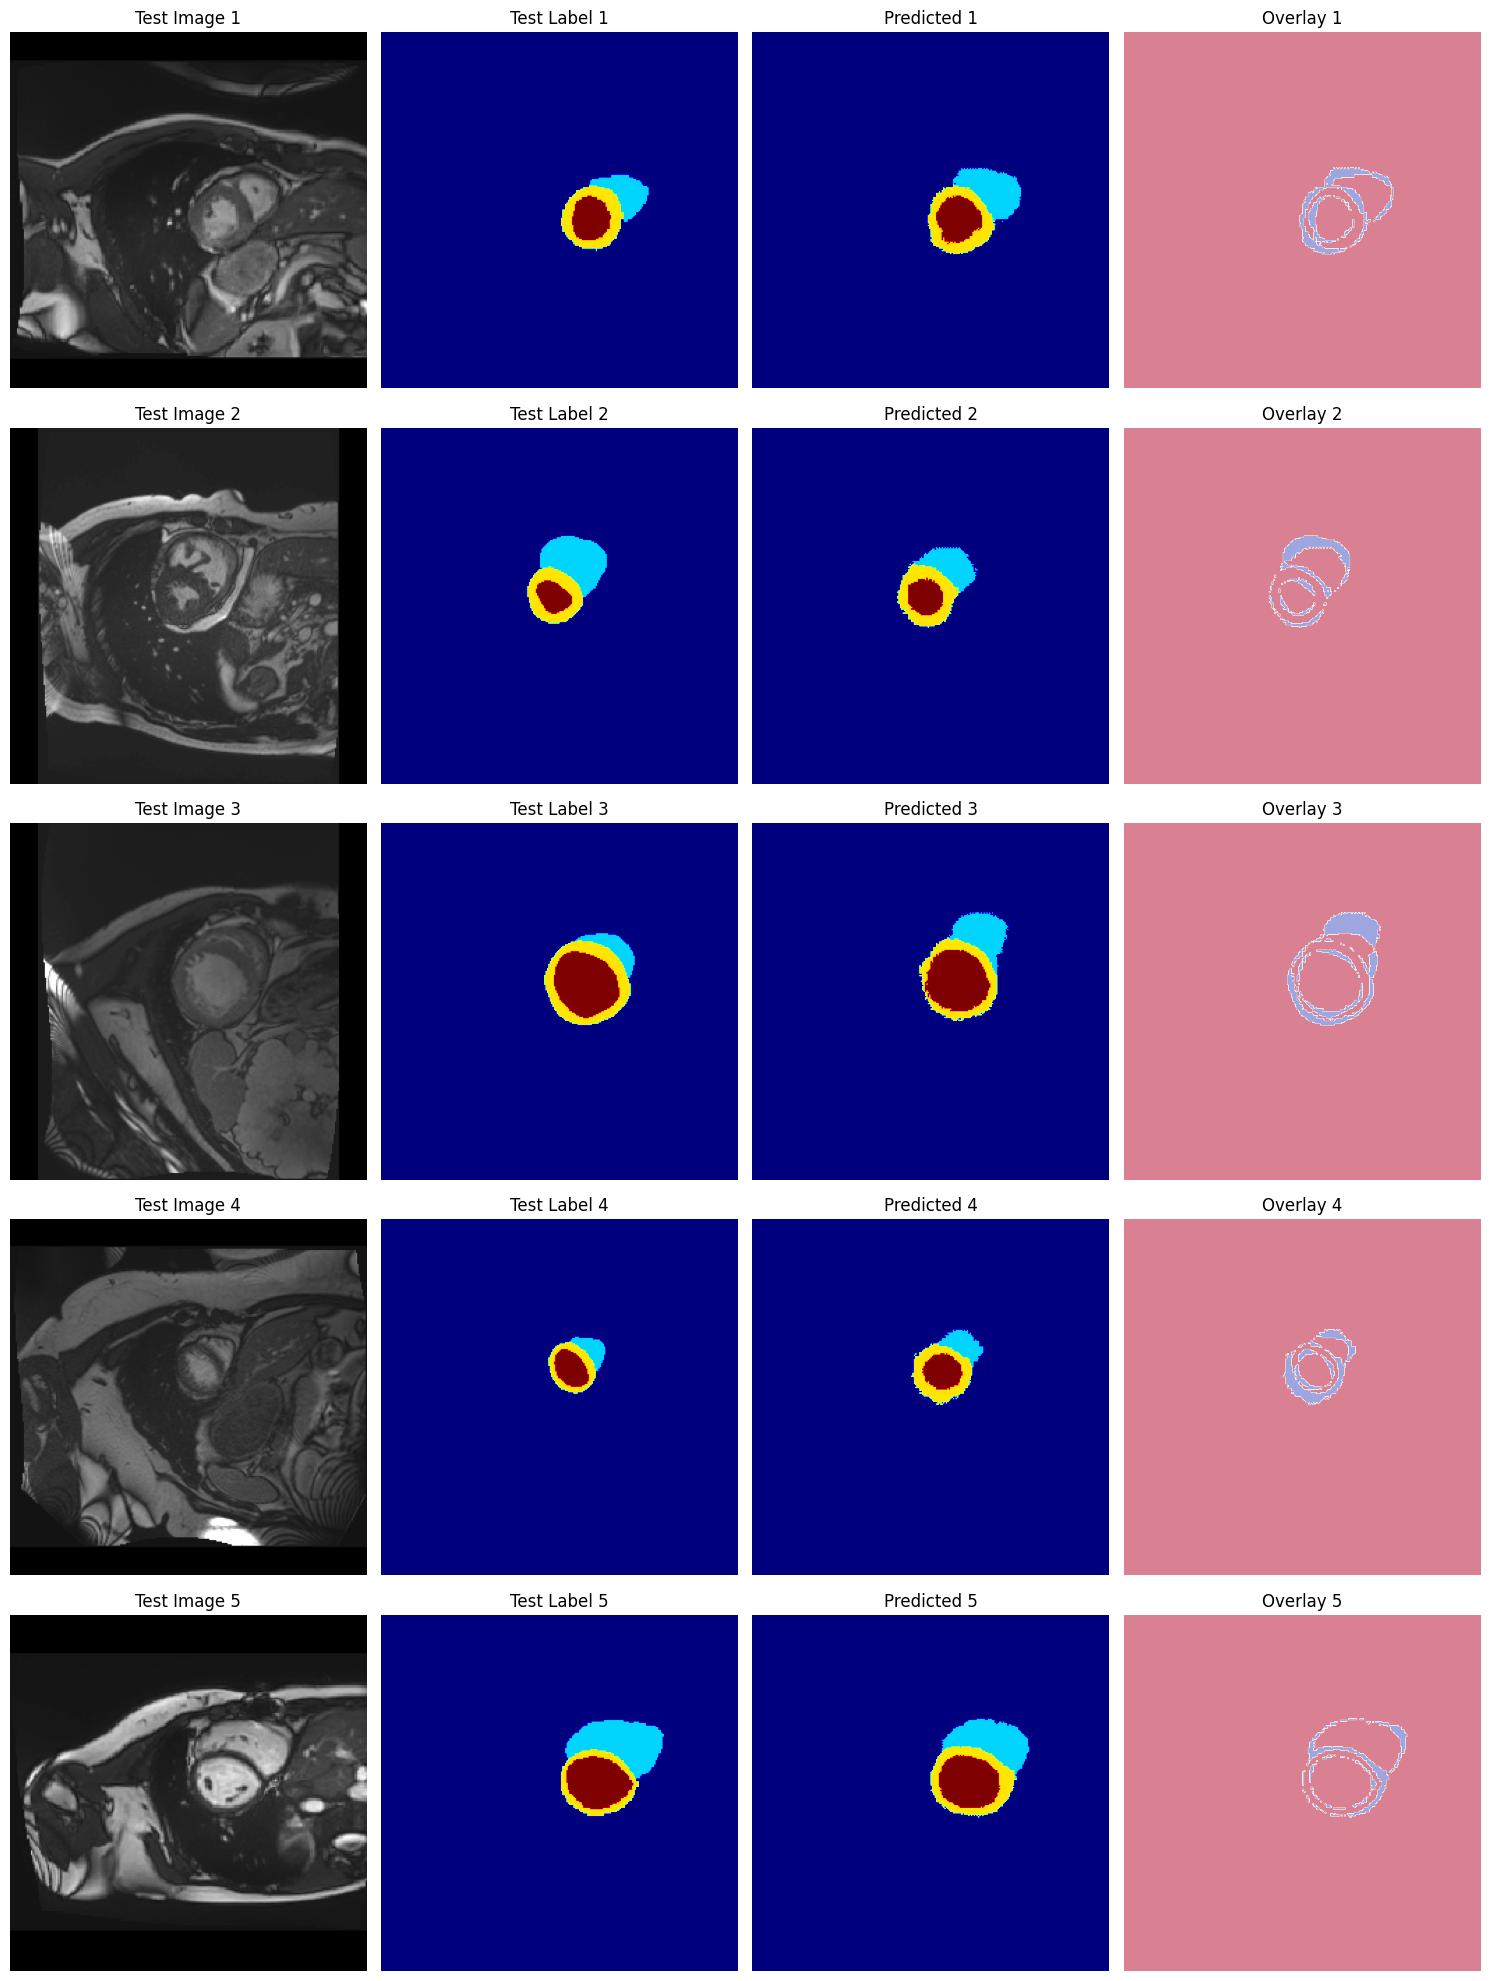

In [108]:
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import numpy as np

# Predict on the test set after training
test_predictions = model(test_images, training=False)  # Get predictions for the test set
test_predictions = tf.argmax(test_predictions, axis=-1)  # Convert to class labels (not one-hot encoded)

# Reshape predictions to match the shape of test_labels (i.e., [batch_size, height, width])
test_predictions = tf.expand_dims(test_predictions, axis=-1)

# Select 5 random samples
indices = random.sample(range(len(test_images)), 5)

# Create a 5x4 grid for plotting (5 rows, 4 columns)
fig, axes = plt.subplots(5, 4, figsize=(15, 20))

for i, idx in enumerate(indices):
    ax1, ax2, ax3, ax4 = axes[i]  # We only have 4 subplots per row

    # Original Test Image
    ax1.imshow(test_images[idx].squeeze(), cmap='gray')
    ax1.set_title(f"Test Image {i+1}")
    ax1.axis('off')

    # Original Test Label
    ax2.imshow(test_labels[idx].squeeze(), cmap='jet')
    ax2.set_title(f"Test Label {i+1}")
    ax2.axis('off')

    # Predicted Label
    ax3.imshow(tf.squeeze(test_predictions[idx]), cmap='jet')  # Predicted Label
    ax3.set_title(f"Predicted {i+1}")
    ax3.axis('off')

    # Overlay (comparing predicted label with test label)
    # Ensure both predicted and ground truth labels are of the same shape
    predicted = tf.squeeze(test_predictions[idx]).numpy()  # Convert to numpy array
    actual = tf.squeeze(test_labels[idx]).numpy()  # Convert to numpy array

    # Creating an overlay where 1 represents matching pixels
    overlay = np.zeros_like(predicted, dtype=np.float32)
    overlay[predicted == actual] = 1  # Mark matching pixels as 1

    ax4.imshow(overlay, cmap='coolwarm', alpha=0.5)  # Overlay heatmap
    ax4.set_title(f"Overlay {i+1}")
    ax4.axis('off')

plt.tight_layout()
plt.show()


In [100]:
# --- Compile and train model ---

# from keras import backend as K
# K.clear_session()  # Clears the current session
# model = MyModel()  # Rebuild your model
# model.compile(optimizer='adam', loss= 'sparse_categorical_crossentropy', metrics=[dice_coefficient_multiclass])

## Accuracy is misleading. Do not use it

# # Model training with tqdm progress bar
# for epoch in tqdm(range(num_epoch), desc="Training Epochs", unit="epoch"):
#     # Use the training data as is, no need to resize train_labels
#     model.fit(train_images, train_labels, epochs=1, batch_size=batch_size, verbose=1)